In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error,r2_score,mean_absolute_percentage_error

In [3]:
powerplus = pd.read_csv("C:/Users/HP/Desktop/kani/Data_science/guvi/Project/Powerplus/individual+household+electric+power+consumption (1)/household_power_consumption.txt",
                  sep = ';', low_memory=False)
powerplus.shape

(2075259, 9)

In [5]:
powerplus.head(5)

,Date,Time,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
0,16/12/2006,17:24:00,4.216,0.418,234.840,18.400,0.000,1.000,17.0
1,16/12/2006,17:25:00,5.360,0.436,233.630,23.000,0.000,1.000,16.0
2,16/12/2006,17:26:00,5.374,0.498,233.290,23.000,0.000,2.000,17.0
3,16/12/2006,17:27:00,5.388,0.502,233.740,23.000,0.000,1.000,17.0
4,16/12/2006,17:28:00,3.666,0.528,235.680,15.800,0.000,1.000,17.0


In [7]:
powerplus.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075259 entries, 0 to 2075258
Data columns (total 9 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   Date                   object 
 1   Time                   object 
 2   Global_active_power    object 
 3   Global_reactive_power  object 
 4   Voltage                object 
 5   Global_intensity       object 
 6   Sub_metering_1         object 
 7   Sub_metering_2         object 
 8   Sub_metering_3         float64
dtypes: float64(1), object(8)
memory usage: 142.5+ MB


In [7]:
powerplus['Datetime'] = pd.to_datetime(
    powerplus['Date'] + ' ' + powerplus['Time'],
    format='%d/%m/%Y %H:%M:%S'
)

In [9]:
powerplus.drop(['Time','Date'], axis=1, inplace=True)
powerplus.head(2)

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3,Datetime
0,4.216,0.418,234.840,18.400,0.000,1.000,17.0,2006-12-16 17:24:00
1,5.360,0.436,233.630,23.000,0.000,1.000,16.0,2006-12-16 17:25:00


In [11]:
powerplus['Global_active_power'] = pd.to_numeric(powerplus['Global_active_power'], errors='coerce')
powerplus['Global_reactive_power'] = pd.to_numeric(powerplus['Global_reactive_power'], errors='coerce')
powerplus['Voltage'] = pd.to_numeric(powerplus['Voltage'], errors='coerce')
powerplus['Sub_metering_1'] = pd.to_numeric(powerplus['Sub_metering_1'], errors='coerce')
powerplus['Sub_metering_2'] = pd.to_numeric(powerplus['Sub_metering_2'], errors='coerce')
powerplus['Global_intensity'] = pd.to_numeric(powerplus['Global_intensity'], errors='coerce')

In [12]:
#validating datatype changes
powerplus.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075259 entries, 0 to 2075258
Data columns (total 8 columns):
 #   Column                 Dtype         
---  ------                 -----         
 0   Global_active_power    float64       
 1   Global_reactive_power  float64       
 2   Voltage                float64       
 3   Global_intensity       float64       
 4   Sub_metering_1         float64       
 5   Sub_metering_2         float64       
 6   Sub_metering_3         float64       
 7   Datetime               datetime64[ns]
dtypes: datetime64[ns](1), float64(7)
memory usage: 126.7 MB


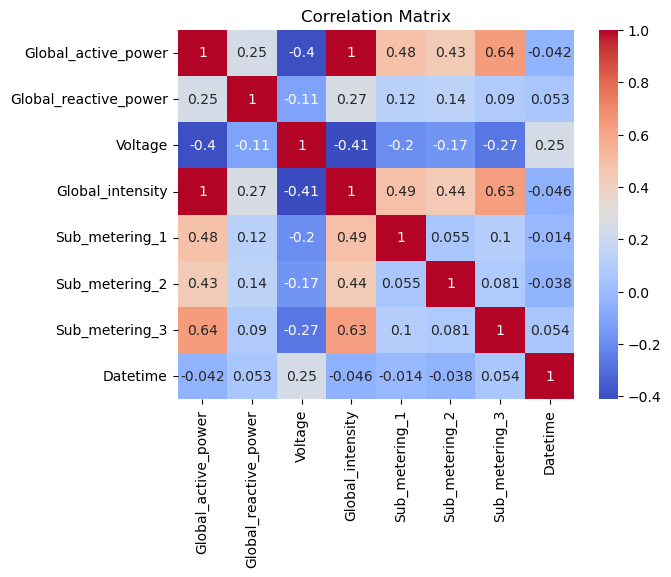

In [15]:
# Correlation Matrix
correlation_matrix = powerplus.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

In [19]:
#handling missing values:
powerplus.isnull().sum()

Global_active_power      25979
Global_reactive_power    25979
Voltage                  25979
Global_intensity         25979
Sub_metering_1           25979
Sub_metering_2           25979
Sub_metering_3           25979
Datetime                     0
dtype: int64

In [17]:
# Impute missing values in numerical columns with the median

columns_to_impute = ['Global_active_power', 'Global_reactive_power', 'Voltage', 
                     'Global_intensity', 'Sub_metering_1', 'Sub_metering_2', 'Sub_metering_3']

# Loop through each column and apply median imputation
for column in columns_to_impute:
    median_value = powerplus[column].median() 
    powerplus[column].fillna(median_value, inplace= True)  # Fill missing values with the median

# Check for remaining missing values (should be 0 if all were filled)
print(powerplus.isnull().sum())

Global_active_power      0
Global_reactive_power    0
Voltage                  0
Global_intensity         0
Sub_metering_1           0
Sub_metering_2           0
Sub_metering_3           0
Datetime                 0
dtype: int64


C:\Users\HP\AppData\Local\Temp\ipykernel_12036\1337800437.py:9: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  powerplus[column].fillna(median_value, inplace= True)  # Fill missing values with the median


In [19]:
numerical_cols = ['Global_active_power', 'Global_reactive_power', 'Voltage',
                  'Global_intensity', 'Sub_metering_1', 'Sub_metering_2', 'Sub_metering_3']
outlier_summary = []

for col in numerical_cols:
    Q1 = powerplus[col].quantile(0.25)
    Q3 = powerplus[col].quantile(0.75)
    IQR = Q3 - Q1
    
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    # Count how many outliers
    outlier_count = ((powerplus[col] < lower_bound) | (powerplus[col] > upper_bound)).sum()
    total_rows = len(powerplus)
    outlier_percent = (outlier_count / total_rows) * 100
    
    outlier_summary.append({
        'Column': col,
        'Outlier_Count': outlier_count,
        'Outlier_%': round(outlier_percent, 2)
    })

outlier_df = pd.DataFrame(outlier_summary)
print(outlier_df)

                  Column  Outlier_Count  Outlier_%
0    Global_active_power          96742       4.66
1  Global_reactive_power          42234       2.04
2                Voltage          54737       2.64
3       Global_intensity         100961       4.86
4         Sub_metering_1         169105       8.15
5         Sub_metering_2          77151       3.72
6         Sub_metering_3              0       0.00


In [21]:
cleaned_powerplus = powerplus.copy()

for col in numerical_cols:
    Q1 = cleaned_powerplus[col].quantile(0.25)
    Q3 = cleaned_powerplus[col].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    cleaned_powerplus = cleaned_powerplus[(cleaned_powerplus[col] >= lower) & (cleaned_powerplus[col] <= upper)]

print("Original shape:", powerplus.shape)
print("After removing outliers:", cleaned_powerplus.shape)


Original shape: (2075259, 8)
After removing outliers: (1739080, 8)


In [23]:
# Extract date and time features
powerplus['hour'] = powerplus['Datetime'].dt.hour
powerplus['day_of_week'] = powerplus['Datetime'].dt.dayofweek
powerplus['year'] = powerplus['Datetime'].dt.year

In [25]:
# Total energy consumption
powerplus['total_energy'] = powerplus['Sub_metering_1'] + powerplus['Sub_metering_2'] + powerplus['Sub_metering_3']

# Proportion of energy consumption for each sub-metering area
powerplus['Sub_metering_1_ratio'] = powerplus['Sub_metering_1'] / powerplus['total_energy']
powerplus['Sub_metering_2_ratio'] = powerplus['Sub_metering_2'] / powerplus['total_energy']
powerplus['Sub_metering_3_ratio'] = powerplus['Sub_metering_3'] / powerplus['total_energy']

# Dealing with nan values
powerplus['Sub_metering_1_ratio'] = powerplus['Sub_metering_1'].fillna(0.0)
powerplus['Sub_metering_2_ratio'] = powerplus['Sub_metering_2'].fillna(0.0)
powerplus['Sub_metering_3_ratio'] = powerplus['Sub_metering_3'].fillna(0.0)
powerplus.info()
powerplus.isnull().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075259 entries, 0 to 2075258
Data columns (total 15 columns):
 #   Column                 Dtype         
---  ------                 -----         
 0   Global_active_power    float64       
 1   Global_reactive_power  float64       
 2   Voltage                float64       
 3   Global_intensity       float64       
 4   Sub_metering_1         float64       
 5   Sub_metering_2         float64       
 6   Sub_metering_3         float64       
 7   Datetime               datetime64[ns]
 8   hour                   int32         
 9   day_of_week            int32         
 10  year                   int32         
 11  total_energy           float64       
 12  Sub_metering_1_ratio   float64       
 13  Sub_metering_2_ratio   float64       
 14  Sub_metering_3_ratio   float64       
dtypes: datetime64[ns](1), float64(11), int32(3)
memory usage: 213.7 MB


Global_active_power      0
Global_reactive_power    0
Voltage                  0
Global_intensity         0
Sub_metering_1           0
Sub_metering_2           0
Sub_metering_3           0
Datetime                 0
hour                     0
day_of_week              0
year                     0
total_energy             0
Sub_metering_1_ratio     0
Sub_metering_2_ratio     0
Sub_metering_3_ratio     0
dtype: int64

In [27]:

scaler = StandardScaler()
features_to_scale = ['Global_active_power', 'Global_reactive_power', 'Voltage', 'Global_intensity',
                     'Sub_metering_1', 'Sub_metering_2', 'Sub_metering_3','total_energy',
                     'Sub_metering_1_ratio','Sub_metering_2_ratio','Sub_metering_3_ratio']
powerplus[features_to_scale] = scaler.fit_transform(powerplus[features_to_scale]) 

In [29]:
y = powerplus[['Global_active_power']]
X = powerplus.drop({'Global_active_power','Datetime'}, axis=1)

In [31]:
#Splitting train and test as 70-30%
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
print(f"train:{X_train.shape}")
print(f"test:{X_test.shape}")

train:(1452681, 13)
test:(622578, 13)


GradientBoosting

In [41]:
from sklearn.ensemble import GradientBoostingRegressor
# Initialize the GradientBoostingRegressor model
model = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, random_state=42) 
# You can adjust n_estimators (trees) and learning_rate for tuning
# Train the model on the training data
model.fit(X_train, y_train)

C:\Users\HP\anaconda3\Lib\site-packages\sklearn\ensemble\_gb.py:668: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)  # TODO: Is this still required?


GradientBoostingRegressor(random_state=42)

In [43]:
# Make predictions on the training set
y_train_pred = model.predict(X_train)

# Make predictions on the test set
y_test_pred = model.predict(X_test)

# Calculate evaluation metrics for the training set
mae_train = mean_absolute_error(y_train, y_train_pred)
mse_train = mean_squared_error(y_train, y_train_pred)
rmse_train = np.sqrt(mse_train)
r2_train = r2_score(y_train, y_train_pred)

# Print the evaluation metrics for the training set
print("Training Set Evaluation on GradientBoosting:")
print(f"Mean Absolute Error (MAE): {mae_train}")
print(f"Mean Squared Error (MSE): {mse_train}")
print(f"Root Mean Squared Error (RMSE): {rmse_train}")
print(f"R-squared (R²): {r2_train}")

# Calculate evaluation metrics for the test set
mae_test = mean_absolute_error(y_test, y_test_pred)
mse_test = mean_squared_error(y_test, y_test_pred)
rmse_test = np.sqrt(mse_test)
r2_test = r2_score(y_test, y_test_pred)

# Print the evaluation metrics for the test set
print("\nTest Set Evaluation on GradientBoosting:")
print(f"Mean Absolute Error (MAE): {mae_test}")
print(f"Mean Squared Error (MSE): {mse_test}")
print(f"Root Mean Squared Error (RMSE): {rmse_test}")
print(f"R-squared (R²): {r2_test}")

Training Set Evaluation on GradientBoosting:
Mean Absolute Error (MAE): 0.02018266011394637
Mean Squared Error (MSE): 0.001050914067303491
Root Mean Squared Error (RMSE): 0.0324178047884722
R-squared (R²): 0.9989485795886749

Test Set Evaluation on GradientBoosting:
Mean Absolute Error (MAE): 0.020255435800183054
Mean Squared Error (MSE): 0.0010720192459089443
Root Mean Squared Error (RMSE): 0.03274170499392089
R-squared (R²): 0.9989291838514615


KNeighborsRegressor

In [45]:
from sklearn.neighbors import KNeighborsRegressor
model = KNeighborsRegressor(n_neighbors=3)
model.fit(X_train,y_train)

KNeighborsRegressor(n_neighbors=3)

In [47]:
# Make predictions on the training set
y_train_pred = model.predict(X_train)

# Make predictions on the test set
y_test_pred = model.predict(X_test)

# Calculate evaluation metrics for the training set
mae_train = mean_absolute_error(y_train, y_train_pred)
mse_train = mean_squared_error(y_train, y_train_pred)
rmse_train = np.sqrt(mse_train)
r2_train = r2_score(y_train, y_train_pred)

# Print the evaluation metrics for the training set
print("Training Set Evaluation:")
print(f"Mean Absolute Error (MAE): {mae_train}")
print(f"Mean Squared Error (MSE): {mse_train}")
print(f"Root Mean Squared Error (RMSE): {rmse_train}")
print(f"R-squared (R²): {r2_train}")

# Calculate evaluation metrics for the test set
mae_test = mean_absolute_error(y_test, y_test_pred)
mse_test = mean_squared_error(y_test, y_test_pred)
rmse_test = np.sqrt(mse_test)
r2_test = r2_score(y_test, y_test_pred)

# Print the evaluation metrics for the test set
print("\nTest Set Evaluation:")
print(f"Mean Absolute Error (MAE): {mae_test}")
print(f"Mean Squared Error (MSE): {mse_test}")
print(f"Root Mean Squared Error (RMSE): {rmse_test}")
print(f"R-squared (R²): {r2_test}")

Training Set Evaluation:
Mean Absolute Error (MAE): 0.02636396507320031
Mean Squared Error (MSE): 0.003028461238524562
Root Mean Squared Error (RMSE): 0.05503145680903389
R-squared (R²): 0.99697007960959

Test Set Evaluation:
Mean Absolute Error (MAE): 0.04168778568515333
Mean Squared Error (MSE): 0.006990376492936652
Root Mean Squared Error (RMSE): 0.08360847141849115
R-squared (R²): 0.9930174686120917


Random Forest Regression

In [35]:
from sklearn.ensemble import RandomForestRegressor
model = RandomForestRegressor(n_estimators = 100, random_state = 10)
model.fit(X_train,y_train)

C:\Users\HP\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


RandomForestRegressor(random_state=10)

In [37]:
# Make predictions on the training set
y_train_pred = model.predict(X_train)

# Make predictions on the test set
y_test_pred = model.predict(X_test)

# Calculate evaluation metrics for the training set
mae_train = mean_absolute_error(y_train, y_train_pred)
mse_train = mean_squared_error(y_train, y_train_pred)
rmse_train = np.sqrt(mse_train)
r2_train = r2_score(y_train, y_train_pred)

# Print the evaluation metrics for the training set
print("Training Set Evaluation:")
print(f"Mean Absolute Error (MAE): {mae_train}")
print(f"Mean Squared Error (MSE): {mse_train}")
print(f"Root Mean Squared Error (RMSE): {rmse_train}")
print(f"R-squared (R²): {r2_train}")

# Calculate evaluation metrics for the test set
mae_test = mean_absolute_error(y_test, y_test_pred)
mse_test = mean_squared_error(y_test, y_test_pred)
rmse_test = np.sqrt(mse_test)
r2_test = r2_score(y_test, y_test_pred)

# Print the evaluation metrics for the test set
print("\nTest Set Evaluation:")
print(f"Mean Absolute Error (MAE): {mae_test}")
print(f"Mean Squared Error (MSE): {mse_test}")
print(f"Root Mean Squared Error (RMSE): {rmse_test}")
print(f"R-squared (R²): {r2_test}")

Training Set Evaluation:
Mean Absolute Error (MAE): 0.004811720180471155
Mean Squared Error (MSE): 9.012098013317555e-05
Root Mean Squared Error (RMSE): 0.009493207052054408
R-squared (R²): 0.9999098355984103

Test Set Evaluation:
Mean Absolute Error (MAE): 0.012921874160484908
Mean Squared Error (MSE): 0.0006628224172615006
Root Mean Squared Error (RMSE): 0.025745337777187943
R-squared (R²): 0.9993379214498941


Neural Networks

In [39]:
from sklearn.neural_network import MLPRegressor
Model = MLPRegressor(hidden_layer_sizes=(64, 32), activation='relu', solver='sgd', max_iter=1000, random_state=42)
Model.fit(X_train, y_train)

C:\Users\HP\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1624: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


MLPRegressor(hidden_layer_sizes=(64, 32), max_iter=1000, random_state=42,
             solver='sgd')

In [41]:
# Make predictions on the training set
y_train_pred = model.predict(X_train)

# Make predictions on the test set
y_test_pred = model.predict(X_test)

# Calculate evaluation metrics for the training set
mae_train = mean_absolute_error(y_train, y_train_pred)
mse_train = mean_squared_error(y_train, y_train_pred)
rmse_train = np.sqrt(mse_train)
r2_train = r2_score(y_train, y_train_pred)

# Print the evaluation metrics for the training set
print("Training Set Evaluation:")
print(f"Mean Absolute Error (MAE): {mae_train}")
print(f"Mean Squared Error (MSE): {mse_train}")
print(f"Root Mean Squared Error (RMSE): {rmse_train}")
print(f"R-squared (R²): {r2_train}")

# Calculate evaluation metrics for the test set
mae_test = mean_absolute_error(y_test, y_test_pred)
mse_test = mean_squared_error(y_test, y_test_pred)
rmse_test = np.sqrt(mse_test)
r2_test = r2_score(y_test, y_test_pred)

# Print the evaluation metrics for the test set
print("\nTest Set Evaluation:")
print(f"Mean Absolute Error (MAE): {mae_test}")
print(f"Mean Squared Error (MSE): {mse_test}")
print(f"Root Mean Squared Error (RMSE): {rmse_test}")
print(f"R-squared (R²): {r2_test}")

Training Set Evaluation:
Mean Absolute Error (MAE): 0.004811720180471155
Mean Squared Error (MSE): 9.012098013317555e-05
Root Mean Squared Error (RMSE): 0.009493207052054408
R-squared (R²): 0.9999098355984103

Test Set Evaluation:
Mean Absolute Error (MAE): 0.012921874160484908
Mean Squared Error (MSE): 0.0006628224172615006
Root Mean Squared Error (RMSE): 0.025745337777187943
R-squared (R²): 0.9993379214498941


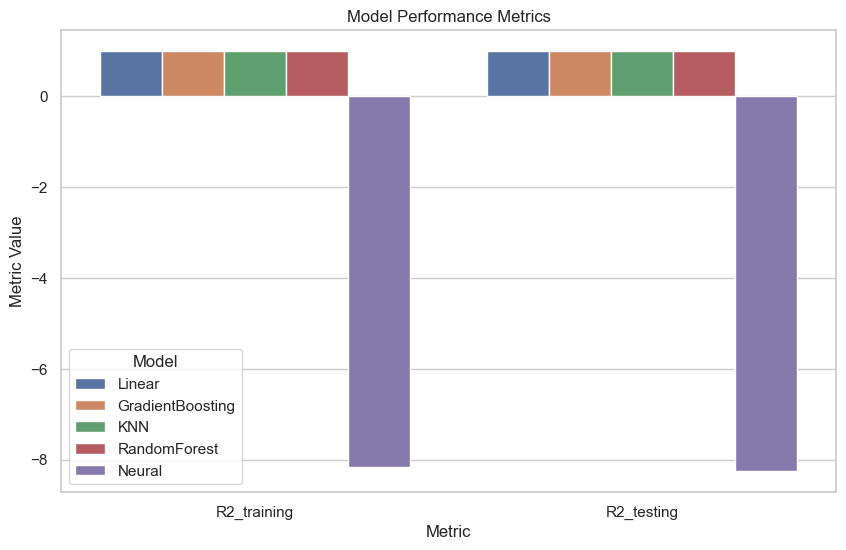

In [43]:
data = {
'Model': ['Linear','GradientBoosting','KNN','RandomForest','Neural'],
'R2_training': [0.998,0.998,0.996,0.999,-8.17],
'R2_testing': [0.998,0.998,0.993,0.999,-8.25]}

df = pd.DataFrame(data)

df_melted = pd.melt(df, id_vars=['Model'], var_name='Metric', value_name='Value')

sns.set(style="whitegrid")

plt.figure(figsize=(10, 6))
sns.barplot(x='Metric', y='Value', hue='Model', data=df_melted)
plt.title('Model Performance Metrics')
plt.ylabel('Metric Value')
plt.xlabel('Metric')
plt.legend(title='Model')
plt.show()